<h1><center>DIGITAL EPIDEMIOLOGY 2018</center></h1>
<h2><center>$1^{st}$ ASSIGNMENT</center></h2>

* **Valerio Guarrasi**

* **Andrea Marcocchia**

* **Marco Minici**

# Table of Contents
0. [Introduction](#0)

1. [Influenza analysis](#1)
     
2. [Other Wikipedia pages](#2)
   
3. [Model](#3)
    
4. [Results](#4)

## PART 0 <a name="0"></a>

Circulating levels of both seasonal and pandemic influenza require constant surveillance to ensure the health and safety of the population. The goal of this assignment is trying to estimate, in near-real time, the level of **influenza-like illness (ILI)** in Italy by monitoring the rate of particular **Wikipedia** article views on a daily basis. We calculated the number of times certain influenza- or health-related Wikipedia articles were accessed each day between July 2015 and Decemcer 2018 and compared these data to official ILI activity levels provided by Influnet (*Rete Italiana Sorveglianza Influenza*).
Each year, there are an estimated 250.000–500.000 deaths worldwide that are attributed to seasonal influenza. In Italy, the Influnet continuously monitors the level of influenza-like illness (ILI) circulating in the population by gathering information from sentinel programs which include virologic data as well as clinical data, such as physicians who report on the percentage of patients seen who are exhibiting influenza-like illness.

To this end, we have created a method of estimating current ILI activity in Italy by gathering information on the number of times particular Wikipedia articles have been viewed. Wikipedia is a massive, user-regulated, online encyclopedia. Launched in 2001, Wikipedia harnesses the power of the online community to create, edit, and modify encyclopedia-like articles that are then freely available to the entire world. Currently operating in 232 languages, Wikipedia has 30 million articles available, expanding at approximately 17,800 articles per day, with nearly 506 million visitors per month, representing 27 billion total page views since its launch, and has approximately 31,000 active Wikipedia editors. With a wealth of detailed information on an almost limitless range of topics, Wikipedia is ideally suited as a platform that could potentially be of use for legitimate scientific investigation in many different areas.

**The purpose of this assignment is to develop a statistical model to provide near real-time estimates of ILI activity in Italy using freely available data gathered from the online encyclopedia, Wikipedia.**

We start by importing the libraries that we used in the project.

In [1]:
import pandas as pd
import datetime
import collections
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn import preprocessing
import numpy as np
from pandas.tools.plotting import lag_plot
from selenium import webdriver
import time
import urllib
from bs4 import BeautifulSoup
import networkx as nx
import shutil
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import math
import platform
import tabula

**In order to correctly execute the next chunk it's mandatory to install Mozilla Firefox**. The browser is available at [this link](https://www.mozilla.org/it/firefox/new/). It's important also to download and store, in the same directory of the Notebook, the **Geckodriver**, that is available [here](https://github.com/mozilla/geckodriver/releases).

Wikimedia Foundation makes available several datasets, tools and APIs to work with page view data. Wikipedia article view information is made freely available by Wikipedia, under a project called Wikimedia Statistics, and is available as the number of article views per hour, which may include multiple views on the same article by the same user. A freely available, user-written tool was independently developed to more easily access the information that Wikipedia makes available (https://bit.ly/2SjFSsd), which aggregates article view data to the day-level, and this tool was used to gather total daily article view information.

**This chunk downloads and saves the click counts for a given Wikipedia page.** Here we process the Wikipedia pageview data for the "Influenza" page of the Italian Wikipedia (https://it.wikipedia.org/wiki/Influenza).

In addition, an article was selected to act as a marker for general background-level activity of normal usage of Wikipedia. For
this matter, information was gathered on the number of times the Wikipedia Italian main page (https://it.wikipedia.org/wiki/Pagina_principale) was accessed per day, as a measure of normal website traffic.

In [2]:
#PART 0
directory = os.getcwd()
#get system
aux = True
while aux == True:
    try:
        platform = platform.system()
        aux = False
    except:
        pass
#empty wikipedia directory and recreate it
try:
    shutil.rmtree(directory+"\\data\\wikipedia")
    os.mkdir(directory+"\\data\\wikipedia")
except:
    os.mkdir(directory+"\\data\\wikipedia")


# Set the parameters to download the file
fp = webdriver.FirefoxProfile()
fp.set_preference("browser.download.folderList",2)
fp.set_preference("browser.download.manager.showWhenStarting",False)
fp.set_preference("browser.download.dir",directory+"\\data\\wikipedia")
fp.set_preference("browser.helperApps.neverAsk.saveToDisk","text/csv")

# Set the driver
if platform == "Windows":
    driver = webdriver.Firefox(firefox_profile=fp, executable_path = './geckodriver.exe')
else:
    driver = webdriver.Firefox(firefox_profile=fp, executable_path = './geckodriver')

def download_wiki_clicks(page_name, directory):
    # Insert the URL
    driver.get("https://tools.wmflabs.org/pageviews/?project=it.wikipedia.org&platform=all-access&agent=user&range=all-time&pages="+page_name)
    # Sleep for some seconds
    time.sleep(3)
    # Click on buttoms
    driver.find_elements_by_tag_name("button")[6].click()
    driver.find_element_by_class_name("download-csv").click()
    #change name of file
    path = directory+"\\data\\wikipedia\\"
    filename = max([path+f for f in os.listdir(path)], key=os.path.getctime)
    os.rename(os.path.join(directory,filename), os.path.join(directory,filename[:-4]+"_"+page_name+".csv"))

page_name = "Influenza"  #numerator
download_wiki_clicks(page_name, directory)
download_wiki_clicks("Pagina_principale", directory) #denominator

## PART 1 <a name="1"></a>

We gathered Wikipedia article view data beginning from the week of July $1^{st}$, 2015, the earliest records available, until
December $5^{th}$, 2018.

When aggregated to weeklevel (thanks to *iso.calendar*), all data sources accounted for 179 weeks of retrospective information, capturing three full influenza seasons. In this way we have a time-series of the click counts of the *"Influenza"* page. To get the rate we divide it by the time-series of the main page and then multiply it by 1000 to be consistent with the incidence of the official data (we will see it later).

In [3]:
# PART 1
# get dates
path = directory+"\\data\\wikipedia\\"
filename = max([path+f for f in os.listdir(path)], key=os.path.getctime)
dates = filename.split("_")[0][-17:]


# get time series of wikipedia page
def get_wiki_time_series(dates, page_name):
    # read csv
    data_wiki_page = pd.read_csv("data/wikipedia/pageviews-"+dates+"_"+page_name+".csv")
    data_wiki_page = data_wiki_page.values.tolist()
    
    # find week of the date
    for i in range(len(data_wiki_page)):
        date = data_wiki_page[i][0].split("-")
        iso_date = datetime.date(int(date[0]), int(date[1]), int(date[2])).isocalendar()
        if iso_date[1] < 10:
            data_wiki_page[i][0] = (str(iso_date[0])+"-0"+str(iso_date[1]))
        else:
            data_wiki_page[i][0] = (str(iso_date[0])+"-"+str(iso_date[1]))
            
    # aggregate by week
    wiki_page = collections.defaultdict(lambda:0)
    for day in data_wiki_page:
        wiki_page[day[0]] += day[1]
    
    # transform in time-series
    wiki_page_ts = pd.DataFrame.from_dict(wiki_page, orient="index", columns = [page_name])
    wiki_page_ts.sort_index(inplace=True)
    return wiki_page_ts

wiki_page_ts = get_wiki_time_series(dates, page_name) #Influenza
denominator_ts = get_wiki_time_series(dates, "Pagina_Principale") #Pagina_Principale
wiki_page_ts = pd.DataFrame(wiki_page_ts.values/denominator_ts.values*1000, index = wiki_page_ts.index, columns = [page_name])

The Italian health protection agency runs a flu surveillance program called *"Influnet"* that uses sentinel doctors. The goal is to estimate the weekly incidence of the flu syndrome during the winter season, so as to describe duration and intensity epidemic.

The official data are reported in PDF files as week-level data, one file for every flu season. The columns used are the $1^{st}$ and the $5^{th}$ that are, respectively, the week of the year and the estimated flu incidence for that week (i.e., fraction in the population of new weekly cases). The incidence is expressed as the number of influenza syndromes (cases) per 1000 assisted for a week. **These data will be the ground truth.** As we did before, we transform these data in time-series.

In [4]:
# load all files from influnet pdfs, create the ground truth
def get_influnet_time_series():
    paths = []
    names = os.listdir('data\\influnet\\pdf')
    for i in names:
        path = 'data\\influnet\\pdf\\'+i
        paths.append(path)
    listDf = []
    for x in paths:
        df = tabula.read_pdf(directory +"\\"+ x, pages=2, silent=True)
        df = df[2:][["Unnamed: 0","Incidenza"]]
        df.columns = ["Settimana","Totale_Incidenza"]
        listDf.append(df)
    ground_truth = pd.concat(listDf)
    
    # transform in time-series
    ground_truth = pd.DataFrame(data = ground_truth["Totale_Incidenza"].values.tolist(), index = ground_truth["Settimana"].values.tolist(), columns = ["Influnet"])
    ground_truth["Influnet"] = ground_truth.apply(lambda x : float(str(x["Influnet"]).replace(",",".")), axis = 1)
    ground_truth.sort_index(inplace=True)
    return ground_truth

ground_truth = get_influnet_time_series()

Unfortunatly, not all of the weeks are present in the official data so, to have conistent time-series, **we must use only the weeks in common between the Wikipedia data and the Influnet data.**

In [5]:
# find intersection of dates
def intersect_dates(wiki_page_ts, ground_truth):
    idx = wiki_page_ts.index.intersection(ground_truth.index)
    wiki_page_ts = wiki_page_ts.loc[idx]
    ground_truth = ground_truth.loc[idx]
    return wiki_page_ts, ground_truth

wiki_page_ts, ground_truth = intersect_dates(wiki_page_ts, ground_truth)

We will later also analyze other related Wikipedia pages, so to keep them all in a container we will use a dictionary.

In [6]:
# save wikipedia timeseries
wiki_time_series_dict = {}
wiki_time_series_dict[page_name] = wiki_page_ts #save Influenza time-series

Here we plot the resulting time series of page views for the current year (2018) and also for previous years (2017-2016-2015), so we can compare it with the time series from the official Influnet surveillance system. We also compute some **measure of correlation (Pearson)** between the two time series. Pearson's correlation coefficient is the covariance of the two variables divided by the product of their standard deviations. The time-series have been normalized, only for a visualization matter.

We can see that, mainly in the last two years, the phrase "If you are sick, google it!" is true. The Pearson coefficient has pretty high levels of correlation, this can be seen also by the similar trend of the two time-series.

Pearson Coefficient 2015 :0.669450899969901


Pearson Coefficient 2016 :0.5701889247042996


Pearson Coefficient 2017 :0.8259680032005622


Pearson Coefficient 2018 :0.9636564625075077




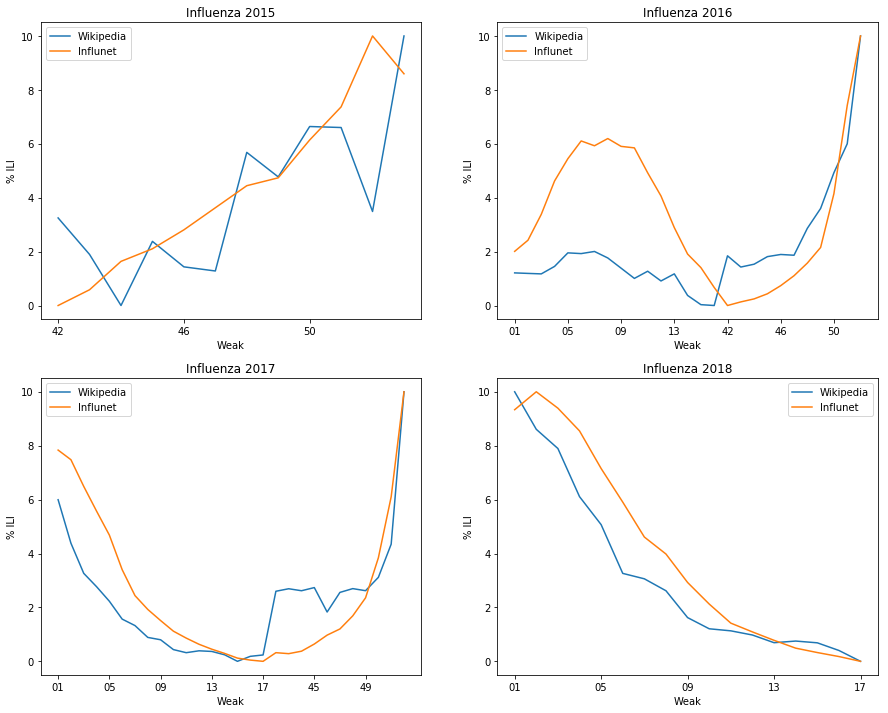

In [7]:
# time-series for each year     
def plot_year_ts(gt_influenza_ts_year, wiki_page_ts_year, year, page_name, assi):
    # normalize gt_influenza_ts_year
    x = gt_influenza_ts_year.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)*10
    gt_influenza_ts_year_normalized = pd.DataFrame(x_scaled, index = gt_influenza_ts_year.index, columns = ["Influnet"])
    # normalize wiki_page_ts_year
    x = wiki_page_ts_year.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)*10
    wiki_page_ts_year_normalized = pd.DataFrame(x_scaled, index = wiki_page_ts_year.index, columns = ["Wikipedia"])
    
    ax = wiki_page_ts_year_normalized.plot(ax = assi, figsize = (15,12))
    ax = gt_influenza_ts_year_normalized.plot(ax = ax)
    labels = []
    ticks = []
    i = 0
    for date,clicks in wiki_page_ts_year_normalized.iterrows():
        if i%4 == 0:
            labels.append(date[5:])
            ticks.append(i)
        i += 1
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Weak")
    ax.set_ylabel("% ILI")
    ax.set_title(page_name +" "+ year)
    #plt.show()

# for each year plot timeseries and pearson coefficient
def year_analysis(year, wiki_page_ts, ground_truth, page_name, assi):
    wiki_page_ts_year = wiki_page_ts.loc[sorted([date for date in wiki_page_ts.index if date[:4] == year])]
    gt_influenza_ts_year = ground_truth.loc[sorted([date for date in ground_truth.index if date in wiki_page_ts_year.index])]
    plot_year_ts(gt_influenza_ts_year, wiki_page_ts_year, year, page_name, assi)
    print("Pearson Coefficient "+ year + " :" + str(stats.pearsonr(gt_influenza_ts_year.values, wiki_page_ts_year.values)[0][0]))
    print("\n")

# for each year show analysis
years = ["2015","2016", "2017", "2018"]
fig, axes = plt.subplots(nrows=2, ncols=2)
a = [0,0,1,1]
b = [0,1,0,1]
i = 0
for year in years:
    year_analysis(year, wiki_page_ts, ground_truth, page_name, axes[a[i],b[i]])
    i += 1

As we did before, now we show the representation of the entire time-series (from 2015 to 2018). We have an overall correlation of *0.86*: very high. This is the start for estimating the Influenza rate via Web clicks.

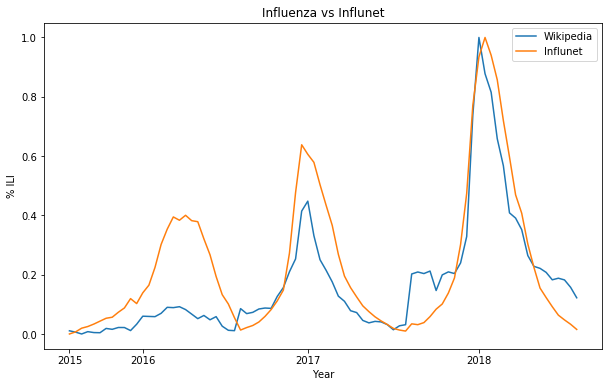

Pearson Coefficient 2015-2018 :0.8579841469472932




In [8]:
# Plot entire time-series
def plot_period_ts(ground_truth, wiki_page_ts, page_name):
    # normalize
    x = ground_truth.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    ground_truth_normalized = pd.DataFrame(x_scaled, index = ground_truth.index, columns = ["Influnet"])
    # normalize
    x = wiki_page_ts.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    wiki_page_ts_normalized = pd.DataFrame(x_scaled, index = wiki_page_ts.index, columns = ["Wikipedia"])
    
    ax = wiki_page_ts_normalized.plot(figsize = (10,6))
    ground_truth_normalized.plot(ax = ax)
    labels = []
    ticks = []
    i = 0
    for date,clicks in ground_truth_normalized.iterrows():
        if date[:4] not in labels:
            labels.append(date[:4])
            ticks.append(i)
        i += 1
    plt.xticks(ticks,labels)
    plt.xlabel("Year")
    plt.ylabel("% ILI")
    plt.title(page_name +" vs Influnet")
    plt.show()

# Plot 2015-2018
plot_period_ts(ground_truth, wiki_page_ts, page_name)

# Pearson 2015-2018
pearson = stats.pearsonr(ground_truth.values, wiki_page_ts.values)[0][0]
print("Pearson Coefficient 2015-2018 :" + str(pearson))
print("\n")

We can see the high correlation between the two time-series also in this scatter plot between their values.

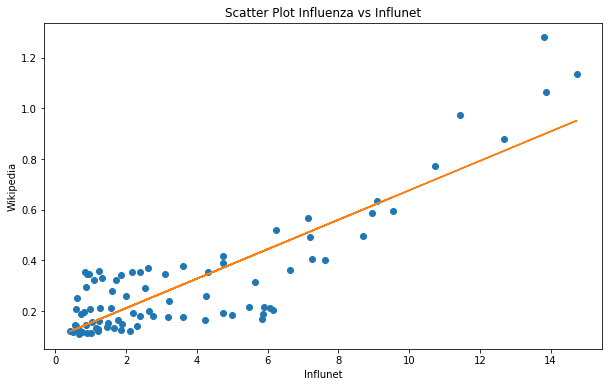

In [9]:
# Scatter Plot
def scatter_plot(ground_truth, wiki_page_ts, page_name):
    x = [item for sublist in ground_truth.values for item in sublist]
    y = [item for sublist in wiki_page_ts.values for item in sublist]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)# Generated linear fit
    line = slope*np.array(x)+intercept
    plt.figure(figsize=(10,6))
    plt.plot(x,y,'o', x, line)
    plt.title("Scatter Plot "+ page_name +" vs Influnet")
    plt.xlabel("Influnet")
    plt.ylabel("Wikipedia")
    plt.show()
    
scatter_plot(ground_truth, wiki_page_ts, page_name)

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag1, the observation at two time steps ago lag2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is the following. It plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis. If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship. If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship. More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship.

We can see for both time-series that there is a strong positive correlation between observations and their lag1 values.

We can repeat this process for an observation and any lag values. For example, we can create a scatter plot for the observation with each value in the previous seven weeks.

In our application we can see that the strongest relationship is between an observation with its lag1 value, but going back in weeks this positive correlation decreases.

C:\Users\guarr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """


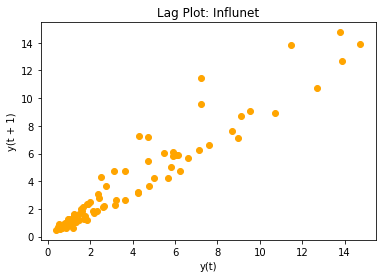

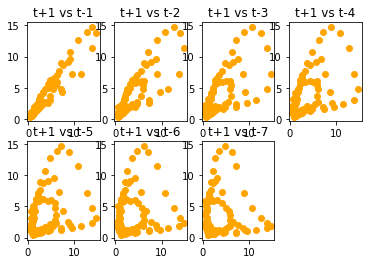

C:\Users\guarr\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  import sys


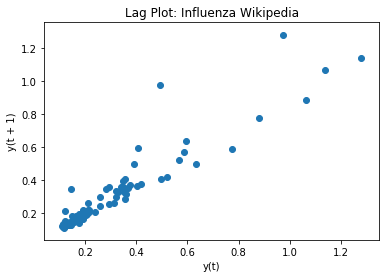

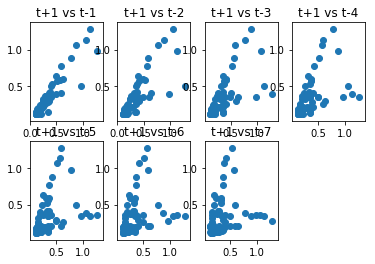

In [10]:
# Ulterior Anlysis
# lag plot
def lag_plots(series, title):
    if title == "Influnet":
        lag_plot(series, c='Orange')
    else:
        lag_plot(series)
    plt.title("Lag Plot: " + title)
    plt.show()
    #more t- i
    values = pd.DataFrame(series.values)
    lags = 7
    columns = [values]
    for i in range(1,(lags + 1)):
        columns.append(values.shift(i))
    dataframe = pd.concat(columns, axis=1)
    columns = ['t+1']
    for i in range(1,(lags + 1)):
        columns.append('t-' + str(i))
    dataframe.columns = columns
    plt.figure(1)
    for i in range(1,(lags + 1)):
        ax = plt.subplot(240 + i)
        ax.set_title('t+1 vs t-' + str(i))
        if title == "Influnet":
            plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values, c="Orange")
        else:
            plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
    plt.show()

lag_plots(ground_truth, "Influnet")
lag_plots(wiki_page_ts, "Influenza Wikipedia")

## PART 2 <a name="2"></a>

In an attempt to use Wikipedia data to estimate ILI activity in Italy, we compiled a **list of Wikipedia articles that were likely to be related to influenza, influenza-like activity, or to health in general.** Our strategy to choose these pages is the following:
**crawl starting from the wiki italian page for influenza using just wiki-links to other pages of related topic. Do this twice: crawl from influenza to all linked pages and do it again for each of them. Store all information to reproduce the graph.**


The goal of this procedure is to augment the number of pages from which the retrieval of click time-series data can help our model to achieve a better accuracy.

Since we are not domain experts and therefore we don't know keywords related to the illness, our actions are driven by an assumption: Wiki pages directly pointed or, at least, pointed by neighbours of the Wiki page of "Influenza" bring useful information to our predictive model.

The main reasons are two:

1- Neighbour pages have similar content and so *influenza-affected* people may click on these pages rather than on "Influenza" and we can't afford to lose these data.

2- Following the theory of the web user walk, there is an high probability that the next web page a user will visit will be one that it is pointed by the current webpage. So, it is reasonable to think that a good amount of clicks on neighbour pages of "Influenza" comes from users who have previously visited the "Influenza" webpage. Since these users are with high probability *influenza-affected*, we want to include their clicks to our dataset.

In [22]:
# Check if a number is float or not
def check_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# crawling
def crawler():
    aux_wiki = ['Aiuto:','PMID','ISBN','File:','Discussioni_modulo:','Speciale:','Categoria:','Template:',"Portale:"]
    # This variable contains all the Wiki URL related to the page "Influenza"
    # at the beginning only the seed page "Influenza" is contained
    seed = ["https://it.wikipedia.org/wiki/Influenza"]
    origin = 'https://it.wikipedia.org'
    d_page_link = {}
    links_store, pages_store, page_final, csv_final = [], [], [], []
    i, k = 0, 2
    while i < k:
        g = 0
        links, csv_cycle = [], []
        # for each wiki page need to be analyzed
        for l in seed:
            while True:
                try:
                    # the html page is downloaded and it is passed to an html parser
                    response = urllib.request.urlopen(l)
                    html = response.read()
                    soup = BeautifulSoup(html, 'html.parser')
                    # each link contained in the html is detected
                    for link in soup.find_all('a'):
                        while True:
                            try:
                                # the URL pointed is retrieved
                                nome_su_csv = link.get('href')
                                wikiId = nome_su_csv[:6]
                                properWiki = nome_su_csv[6:]
                                linka = origin+link.get('href')
                                pagia = link.get('title')
                                # checks to be sure that the page is a page of interest for us
                                if (wikiId in ['/wiki/'] and "Wikipedia" not in pagia and pagia not in ['.doc'] and not any([wk in properWiki for wk in aux_wiki]) and not check_float(properWiki)):
                                    d_page_link[pagia] = linka
                                    # a tuple containing:
                                    # 1- @i which is how many edges this page is far from the seed page
                                    # "Influenza", so the page "Influenza" will be at a level equal to 0
                                    # the direct neighbours will be at 1 and so on and so forth.
                                    # 2- the baseURL, "https://it.wikipedia.org/wiki/Influenza" 
                                    # -> "https://it.wikipedia.org/wiki/
                                    # 3- the wiki name of the page
                                    page_final.append((i,l[30:],properWiki))
                                    csv_cycle.append(properWiki)
                                    links.append(linka)
                                    links_store.append(linka)
                                    pages_store.append(pagia)
                                break
                            except TypeError:
                                break
                    g += 1
                    break
                except urllib.error.HTTPError:
                    break
        links = sorted(set(links))
        seed = np.copy(links)
        csv_final.append(csv_cycle)
        i += 1
    return page_final, csv_final

page_final, csv_final = crawler()

Now we create the graph. **The graph is huge so we need to do some cleaning.** Take away nodes that are not highly connected to the pages directly linked to Influenza. To reach a number of pages small enough we had to remove all nodes that didn't have at least 130 connections with the neighbours of Influenza. We did some testing to choose the appropriate value of this parameter.
We can see that we removed 15620 pages. Obviously, we need to remove the "Influenza" and the main page from this list, since we already have processed their time-series. In this way we selected 10 Wikipedia pages. Since we are not sattisfied we added other articles that were selected based on previous knowledge of the subject area, previously published materials, and expert opinion (Professor C. Cattuto).

At the end we print the pages that represent more or less the hard core of the graph.

In [36]:
def select_pages(page_final, csv_final):
    G = nx.Graph()
    for x in page_final:
        from_page, to_page, cycle = x[1], x[2], x[0]
        G.add_edge(from_page,to_page)
    print ("FROM: ", len(G.nodes()))
    cycle_one = set(csv_final[0])
    threshold = 130    
    removed_pages = []
    for x in G.nodes():
        bool_check = False
        c = 0
        for y in G.neighbors(x):
            if y in cycle_one and c == threshold :
                bool_check = True
                break
            elif y in cycle_one and c < threshold:
                c+=1
        if not bool_check:
            removed_pages.append(x)
    G.remove_nodes_from(removed_pages)
    G.remove_nodes_from(["Influenza","Pagina_principale"])
    print ("TO: ", len(G.nodes()))
    related_pages = ["Vaccino_antinfluenzale",'Vaccino_influenza_stagionale','Vaccino',
                     'Febbre',"Rinorrea","Mialgia","Cefalea","Vomito","Paracetamolo"]
    for x in G.nodes():
        related_pages.append(x)
    related_pages = list(set(related_pages))
    return related_pages

related_pages = select_pages(page_final, csv_final)
print("The related pages are: ")
print(related_pages)

FROM:  15638
TO:  10
The related pages are: 
['Influenzavirus_C', 'SARS', 'Vaccino_influenza_stagionale', 'Rinorrea', 'Vaccino', 'Rinite', 'Croup', 'Broncopneumopatia_cronica_ostruttiva', 'Vaccino_antinfluenzale', 'Mialgia', 'Faringite', 'Vomito', 'Febbre', 'Faringite_streptococcica', 'Sarcoidosi', 'Bronchite', 'Asma', 'Cefalea', 'Paracetamolo']


Are all of these pages ok? Maybe not. So we did some feature selection looking at the **Pearson Coefficient** between the new time-series (which we download and elaborate as we did with the "Influenza" page) and the ground truth. If the Correlation is lower than 0.5 (low correlation) we won't consider the page as relevant or related. Instead, when the there is enough correlation, we save the time-series and we show, as before, its plot (year by year and for all the period) with the respective Pearson Correlation and the scatter plot. We chose this threshold of correlation in a way that we get a sufficient number of pages.

The related pages that come out in the end are: *Vomito*, *Influenzavirus_C*, *Rinorrea*, *Febbre*, *Bronchite*, *Paracetamolo* and *Mialgia*. 

All of these pages are really related to the word Influenza, some are more technical words and some are more "everyday" words.

We can see that **the page "Febbre" has a higher correlation with the ground truth than the "Influenza" page**. This is probably given by the fact that Febbre is a more common (and therefore more searched) word than the pathology Influenza.

Influenzavirus_C : 0.7787441516391997


Selected Page: Influenzavirus_C




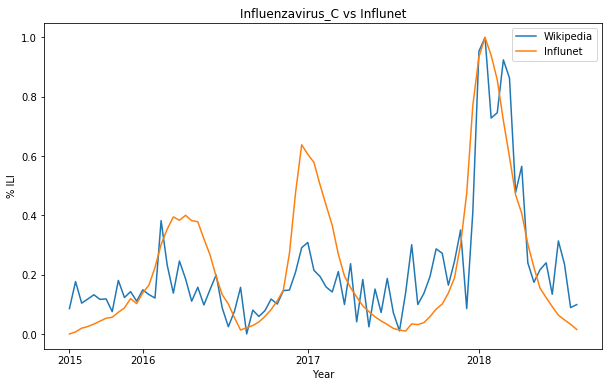

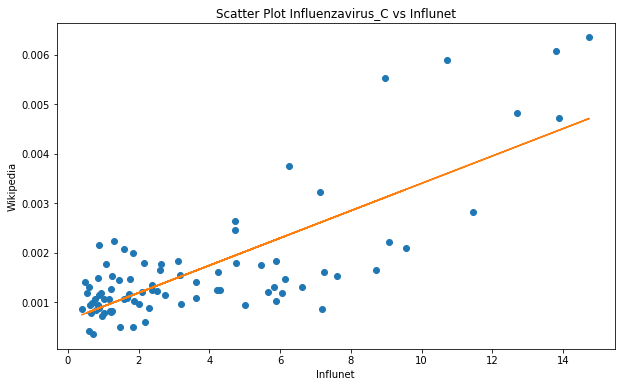

Pearson Coefficient 2015-2018 :0.7787441516391997


SARS : 0.36863440343947196


Vaccino_influenza_stagionale : 0.4072119695898242


Rinorrea : 0.6041771789199498


Selected Page: Rinorrea




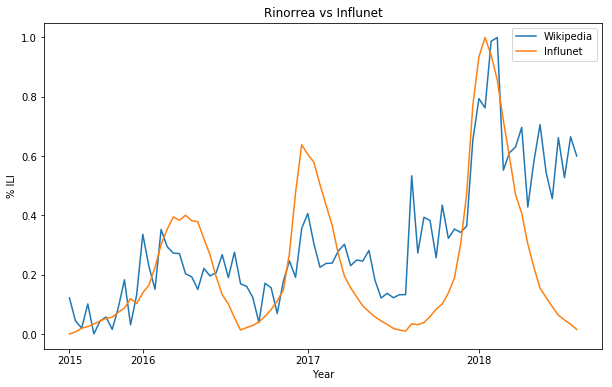

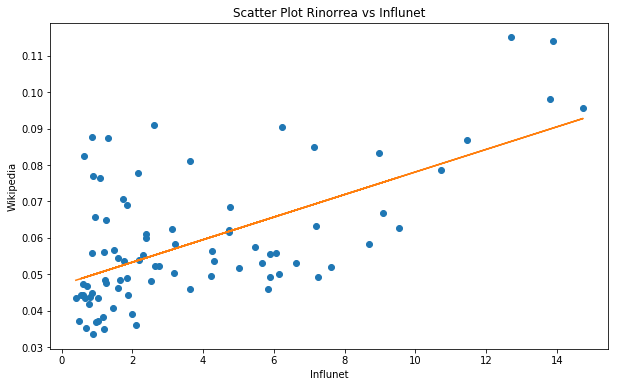

Pearson Coefficient 2015-2018 :0.6041771789199498


Vaccino : 0.27900071407947236


Rinite : 0.4143207751016808


Croup : 0.4067559711360754


Broncopneumopatia_cronica_ostruttiva : 0.3883811009367041


Vaccino_antinfluenzale : 0.239018002826438


Mialgia : 0.5078102524979116


Selected Page: Mialgia




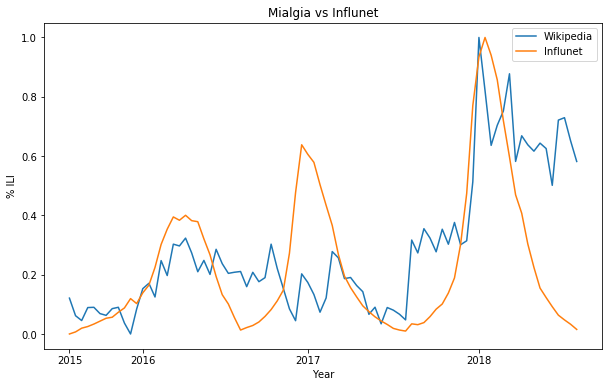

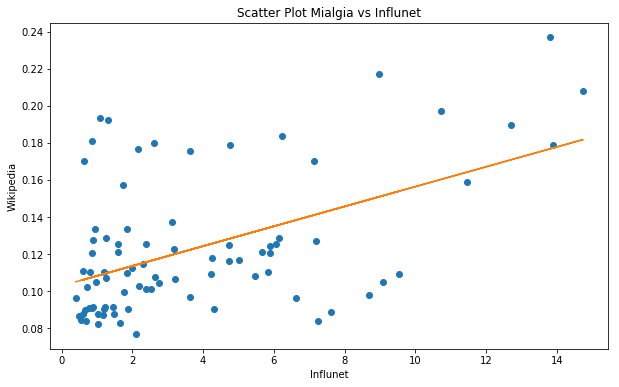

Pearson Coefficient 2015-2018 :0.5078102524979116


Faringite : 0.45110286823202855


Vomito : 0.5799719390936583


Selected Page: Vomito




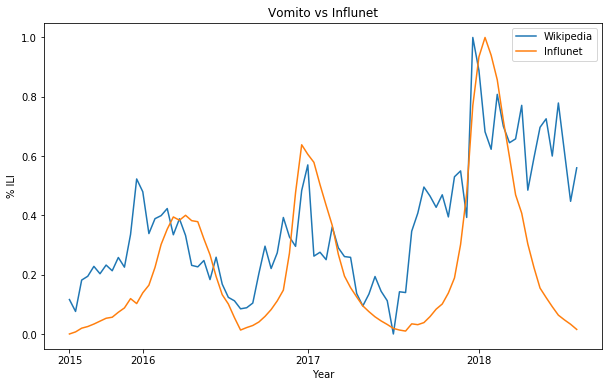

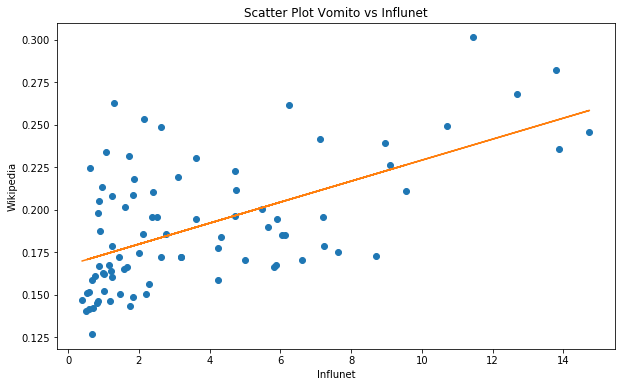

Pearson Coefficient 2015-2018 :0.5799719390936583


Febbre : 0.8989282509848143


Selected Page: Febbre




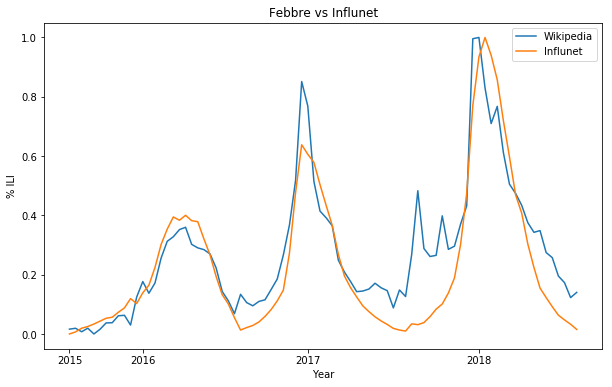

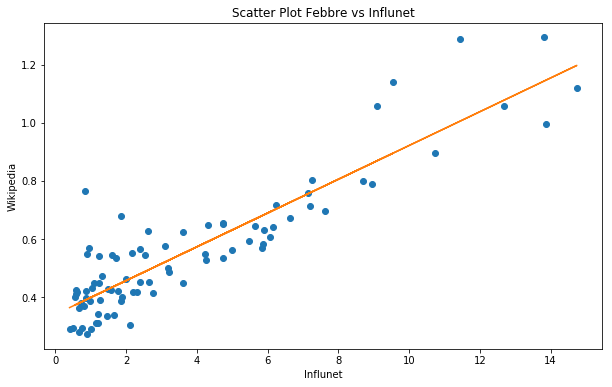

Pearson Coefficient 2015-2018 :0.8989282509848143


Faringite_streptococcica : 0.29073016104617966


Sarcoidosi : 0.341527881690913


Bronchite : 0.7184924194293625


Selected Page: Bronchite




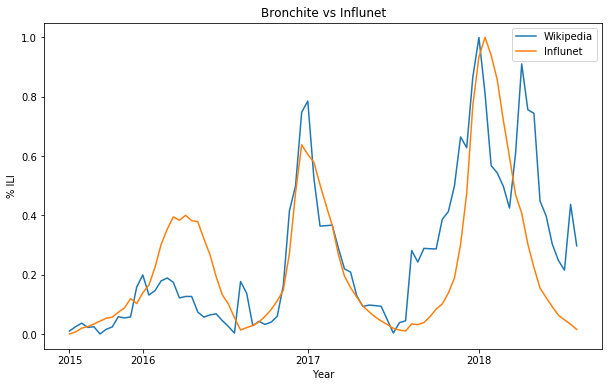

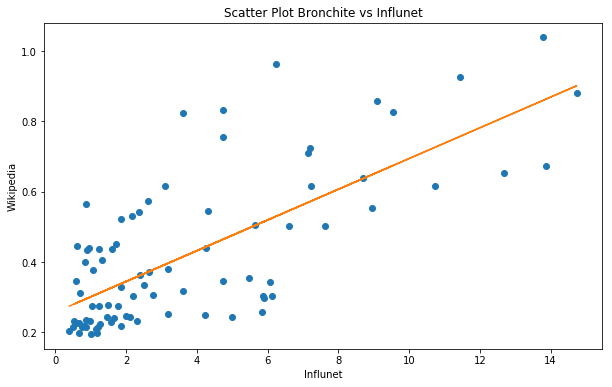

Pearson Coefficient 2015-2018 :0.7184924194293625


Asma : 0.3422989314745516


Cefalea : 0.45454442768599695


Paracetamolo : 0.6710955336502437


Selected Page: Paracetamolo




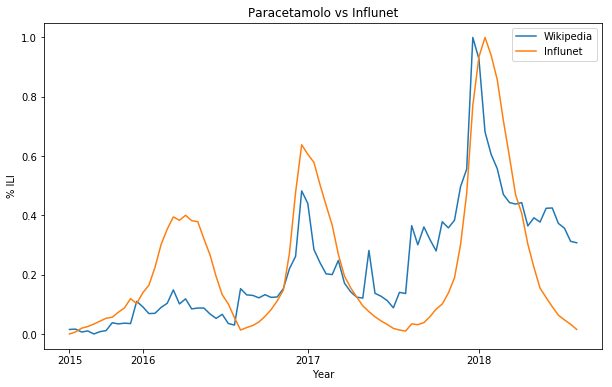

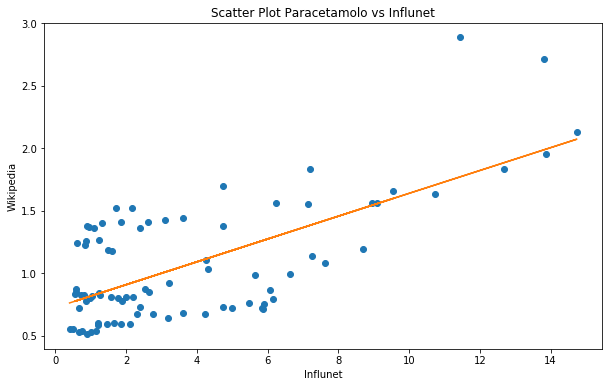

Pearson Coefficient 2015-2018 :0.6710955336502437




In [37]:
# Analisys on related pages
def related_pages_analysis(related_pages, ground_truth, denominator_ts):
    for page_name in related_pages:
        #get wiki clicks for the related pages
        try:
            download_wiki_clicks(page_name, directory)
        except:
            pass
        # get time series of wikipedia page
        wiki_page_ts = get_wiki_time_series(dates, page_name)
        #use denominator
        wiki_page_ts = pd.DataFrame(wiki_page_ts.values/denominator_ts.values*1000, index = wiki_page_ts.index, columns = [page_name])
        # find common dates with ground truth
        wiki_page_ts, ground_truth = intersect_dates(wiki_page_ts, ground_truth)
        # find complete pearson coefficient
        pearson = stats.pearsonr(ground_truth.values, wiki_page_ts.values)[0][0]
        print(page_name + " : " + str(pearson))
        print("\n")
        # select only the pages that have total correlation >= 0.5
        if pearson >= 0.5:
            print("Selected Page: " + page_name)
            print("\n")
            #save time-series
            wiki_time_series_dict[page_name] = wiki_page_ts
            #Plot 2015-2018
            plot_period_ts(ground_truth, wiki_page_ts, page_name)
            #scatter plot
            scatter_plot(ground_truth, wiki_page_ts, page_name)
            #Pearson Coefficient
            print("Pearson Coefficient 2015-2018 :" + str(pearson))
            print("\n")

related_pages_analysis(related_pages, ground_truth, denominator_ts)

## PART 3 <a name="3"></a>

Here we build a **regression model that predicts the Influnet incidence for a given week based on the Wikipedia pageview data for the same week.** We used 5 different models. The all run with the following function "model". 

The pipe-line is the following:
    1. create the dataset
    2. divide the indepedent (X) and independent (y) variables
    3. split the dataset in train (2/3) and test (1/3)
    4. choose the regressor
    5. fit the model
    6. evaluate the performance via cross-validation (folds = 10)
    7. use as evaluation measure MSE and Pearson Correlation with the ground truth
    8. predict the last week: "2018-17"
    9. plot the prediction of the Influnet incidence in respect to the ground truth

In [38]:
def model(dataset, regressor, mse_list, corr_list, i):
    # Data Preprocessing
    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1].values.reshape(-1, 1)
    
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)
        
    # Fitting Simple Linear Regression to the Training set
    regressor.fit(X_train, y_train)
    
    # Applying k-Fold Cross Validation: cv: number of folds I want to split the dataset
    error = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, scoring = "neg_mean_squared_error")
    mse = round(error.mean(),3)*(-1)
    mse_list.append(mse)
    print("Mean MSE: "+ str(mse))
    print("Range of MSE: " +str(round(error.max()*(-1),3)) +" - "+str(round(error.min()*(-1),3)))
    print("\n")
    
    #Predict one week
    week_to_predict = "2018-17"
    idx = dataset.index.tolist().index(week_to_predict)
    y_pred = regressor.predict(X[idx].reshape(1, -1))[0]#[0]
    print("Prediction of week " + week_to_predict +": " +str(y_pred))
    print("Real Value of week " + week_to_predict +": " +str(y[idx][0]))
    print("\n")
    
    #Plot time-series to show result
    prediction_ts = pd.DataFrame(regressor.predict(X), index = ground_truth.index, columns=["Prediction"])
    ax = prediction_ts.plot(figsize = (10,6))
    ground_truth.plot(ax = ax)
    labels = []
    ticks = []
    j = 0
    for date,clicks in ground_truth.iterrows():
        if date[:4] not in labels:
            labels.append(date[:4])
            ticks.append(j)
        j += 1
    plt.xticks(ticks,labels)
    plt.xlabel("Year")
    plt.ylabel("% ILI")
    plt.title("Model "+ str(i) +" vs Influnet")
    plt.show()
    
    #Pearson Coefficient between Prediction and Ground-truth
    corr = stats.pearsonr(ground_truth.values, prediction_ts.values)[0][0]
    corr_list.append(corr)
    print("Pearson Coefficient :" + str(corr))
    print("\n")
    
        
#Save for each different model the mean deviance
mse_list = []
corr_list = []

From now on, the only things that change from one model to the other are the features in the dataset and the type of regressor model.

### Model 1

This is the most simple model (also the worst one). Here there is **only one feature:** the Wikipedia pageview counts for the "Influenza" page. **The model used is a simple Linear Regressor.**

Model Number: 1


Mean MSE: 3.833
Range of MSE: 1.998 - 6.723


Prediction of week 2018-17: [2.98044831]
Real Value of week 2018-17: 0.62




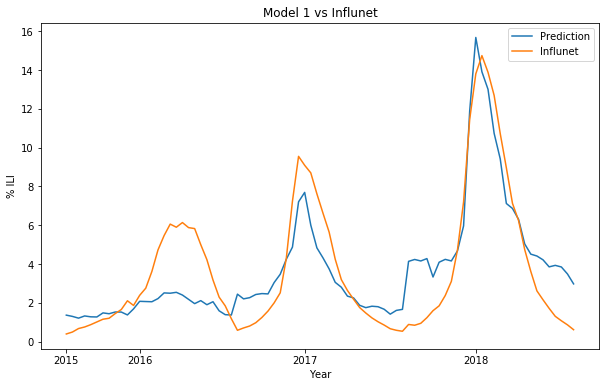

Pearson Coefficient :0.8579841469472932






In [39]:
#Counter for the Model
i = 1
print("Model Number: " + str(i))
print("\n")
#Only Influenza Wikipedia as feature
dataset = pd.concat([wiki_time_series_dict["Influenza"], ground_truth], axis=1)
#choose regressor
regressor = LinearRegression()
#Results
model(dataset, regressor, mse_list, corr_list, i)
i += 1
print("\n")

### Model 2

**The features are: the Wikipedia pageview counts for the "Influenza" page and for all the pages you have selected in the previus part**. In addition to a variable representing the year being included in the models, the week was also controlled for in an effort to adjust for the seasonal patterns that influenza outbreaks exhibit in Italy.
As before, **the model used is a Linear Regressor.**

Model Number: 2


Mean MSE: 1.978
Range of MSE: 0.176 - 4.982


Prediction of week 2018-17: [0.27444617]
Real Value of week 2018-17: 0.62




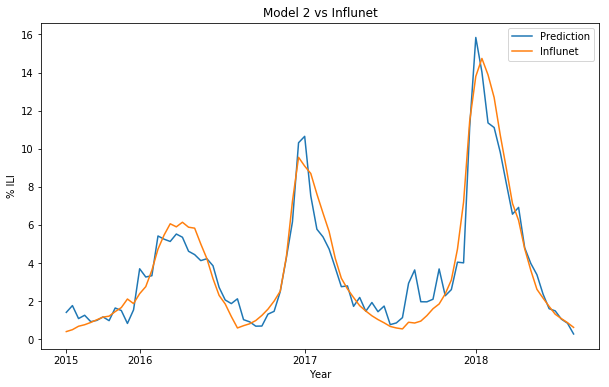

Pearson Coefficient :0.9628706585560238






In [40]:
print("Model Number: " + str(i))
print("\n")
#Dataset with selected pages and time(Year and weak)
#extract year
years = pd.DataFrame([int(idx[:4]) for idx in ground_truth.index], index = ground_truth.index, columns = ["Year"])
#extract weaks
weaks = pd.DataFrame([int(idx[-2:]) for idx in ground_truth.index], index = ground_truth.index, columns = ["Weak"])
#create dataset
dataset = pd.concat([years, weaks, ground_truth], axis=1)
for page_name in wiki_time_series_dict:
    dataset = pd.concat([wiki_time_series_dict[page_name], dataset], axis=1)
#choose regressor
regressor = LinearRegression()
#Results
model(dataset, regressor, mse_list, corr_list, i)
i += 1
print("\n")

### Model 3

Maintaining the same regressor, here the dataset puts some **information regarding the previus week.** Taking the same dataset of model 2 we added these features: the Influnet incidence for the week preceding the target week and the pageview counts for all the pages selected for the week preceding the target week.

Model Number: 3


Mean MSE: 0.689
Range of MSE: 0.037 - 2.277


Prediction of week 2018-17: [-0.3733439]
Real Value of week 2018-17: 0.62




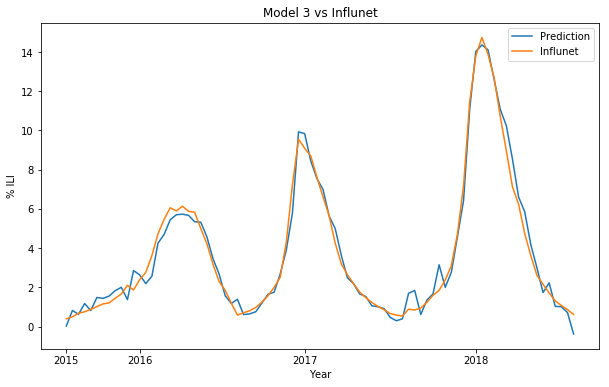

Pearson Coefficient :0.9889527858127585






In [41]:
print("Model Number: " + str(i))
print("\n")
#extract the influnet values, excluding the first in order to
#append it to the original dataset to include in the model
#the real values of the previous week
influnet_prev = pd.DataFrame(data = [0]+dataset.iloc[:, -1].values.tolist()[:-1], columns = ["influnet_prev"], index = dataset.index)
dataset = pd.concat([dataset.iloc[:, :-1],influnet_prev,dataset.iloc[:,-1]], axis = 1)
count_prev = pd.DataFrame(data = [[0]*8]+dataset.iloc[:, :8].values.tolist()[:-1], columns = [column+"_prev" for column in dataset.columns[:8]], index = dataset.index)
dataset = pd.concat([dataset.iloc[:, :-1],count_prev,dataset.iloc[:,-1]], axis = 1)
#choose regressor
regressor = LinearRegression()
#Results
model(dataset, regressor, mse_list, corr_list, i)
i += 1
print("\n")

We are ok with our dataset. **Let's start changing the regressor.** To get the best possible model, **GLM** needs to find the optimal values of the regularization parameters $\alpha$ and $\lambda$. When performing regularization, penalties are introduced to the model buidling process to avoid overfitting, to reduce variance of the prediction error, and to handle correlated predictors. **The two most common penalized models are ridge regression and LASSO (least absolute shrinkage and selection operator).**

In Model 4 we use Lasso and in Model 5 we use Ridge. We used Grid Search for tuning the hyper-parameters.

### Model 4

Model Number: 4


Mean MSE: 0.573
Range of MSE: 0.084 - 1.825


Prediction of week 2018-17: 0.6355745368779253
Real Value of week 2018-17: 0.62




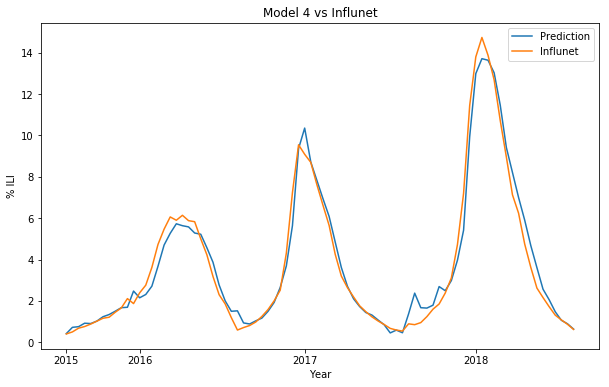

Pearson Coefficient :0.9853603878496562






In [42]:
print("Model Number: " + str(i))
print("\n")
#with Lasso
regressor = linear_model.Lasso(alpha=0.01, normalize=True)
#Results
model(dataset, regressor, mse_list, corr_list, i)
i += 1
print("\n")

### Model 5

Model Number: 5


Mean MSE: 0.497
Range of MSE: 0.102 - 1.874


Prediction of week 2018-17: [0.37468044]
Real Value of week 2018-17: 0.62




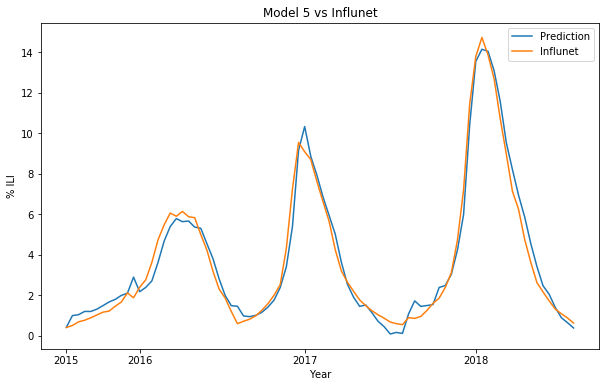

Pearson Coefficient :0.9869535489673285






In [43]:
print("Model Number: " + str(i))
print("\n")
#with Ridge
regressor = linear_model.Ridge(alpha=0.5)
#Results
model(dataset, regressor, mse_list, corr_list, i)
i += 1
print("\n")

### McIver Model

**To see how we performed we tried to reproduce the the model presented by McIver and Brownstein in 2014.** The model to estimate the ILI activity using Wikipedia article view information were developed using a generalized linear model framework. The outcome variable is a proportion and is therefore appropriately modeled using a Poisson distribution, and so the Poisson family was used in the GLM framework, with a log-link function. Here Lasso regulariztion was used. Lasso regression dynamically and automatically selects predictor variables for inclusion or exclusion by penalizing the absolute size of the regression coefficients toward zero, thereby selecting a subset of predictor variables which best describe the outcome data.

Article Model


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,18 mins 31 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,9 months and 2 days !!!
H2O cluster name:,H2O_from_python_guarr_vhstx7
H2O cluster total nodes:,1
H2O cluster free memory:,3.204 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


C:\Users\guarr\Anaconda3\lib\site-packages\h2o\utils\shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Mean Deviation: 1.359
Range of Deviation: 0.19592479 - 0.53757304


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Prediction of week 2018-17: 1.3039605468781146
Real Value of week 2018-17: 0.62


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


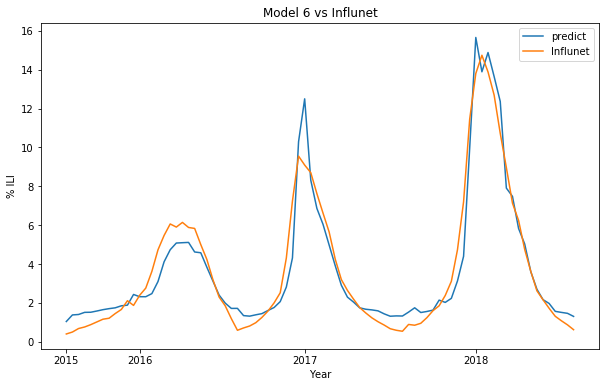

Pearson Coefficient :0.9642126979314584




In [44]:
#Article Model
def mciver_model(dataset):
    print("Article Model")
    print("\n")
    #GeneralizedLinearEstimator Poisson with Lasso???
    h2o.init()
    #http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html
    
    predictors = list(dataset.columns[:-1])
    response_col = dataset.columns[-1]
    
    glm_model = H2OGeneralizedLinearEstimator(family= "poisson", nfolds = 10, alpha = 1, lambda_search = True,standardize = True, link = "log")
    glm_model.train(predictors, response_col, training_frame= h2o.H2OFrame(dataset))
    
    results = glm_model.cross_validation_metrics_summary()
    mean_mse_article = round(float(results["mean"][2]),3)
    min_range = min([results["cv_1_valid"][1],results["cv_2_valid"][1],results["cv_3_valid"][1],results["cv_4_valid"][1]])
    max_range = max([results["cv_1_valid"][1],results["cv_2_valid"][1],results["cv_3_valid"][1],results["cv_4_valid"][1]])
    print("Mean Deviation: "+ str(mean_mse_article))
    print("Range of Deviation: " + min_range +" - "+ max_range)
    print("\n")
    
    #Predict one week
    week_to_predict = "2018-17"
    y_pred = glm_model.predict(h2o.H2OFrame(dataset.iloc[-1:, :-1])).as_data_frame().values[0][0]
    print("Prediction of week " + week_to_predict +": " +str(y_pred))
    print("Real Value of week " + week_to_predict +": " +str(dataset.iloc[-1:, -1].values[0]))
    print("\n")
    
    #Plot time-series to show result
    prediction_ts = glm_model.predict(h2o.H2OFrame(dataset.iloc[:, :-1])).as_data_frame()
    
    ax = prediction_ts.plot(figsize = (10,6))
    ground_truth.plot(ax = ax)
    labels = []
    ticks = []
    j = 0
    for date,clicks in ground_truth.iterrows():
        if date[:4] not in labels:
            labels.append(date[:4])
            ticks.append(j)
        j += 1
    plt.xticks(ticks,labels)
    plt.xlabel("Year")
    plt.ylabel("% ILI")
    plt.title("Model "+ str(i) +" vs Influnet")
    plt.show()
    
    #Pearson Coefficient between Prediction and Ground-truth
    corr_article = stats.pearsonr(ground_truth.values, prediction_ts.values)[0][0]
    print("Pearson Coefficient :" + str(corr_article))
    print("\n")
    
    return mean_mse_article, corr_article
    
mean_mse_article, corr_article = mciver_model(dataset)

## Results <a name="4"></a>

Models are compared to one another by comparing the MSE (the lower the better) and the Pearson Correlation Coefficient (the higher the better). 

**Which model is the best?** It depends on what measure is more important for the user. Certainly the war is between models 3, 4 and 5. The GMM (Guarrasi, Marcocchia, Minici) are the results of our models. From these plots we can deduce that we did a better job than the article, but maybe this happens because the parameters chosen for there model aren't the best ones and the dataset is different. We can for sure say that, the dataset with all the information is certainly the best one and that a regularization method is needed.

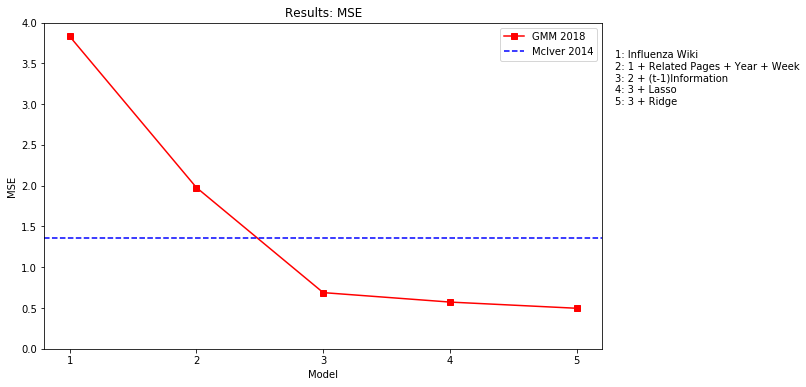

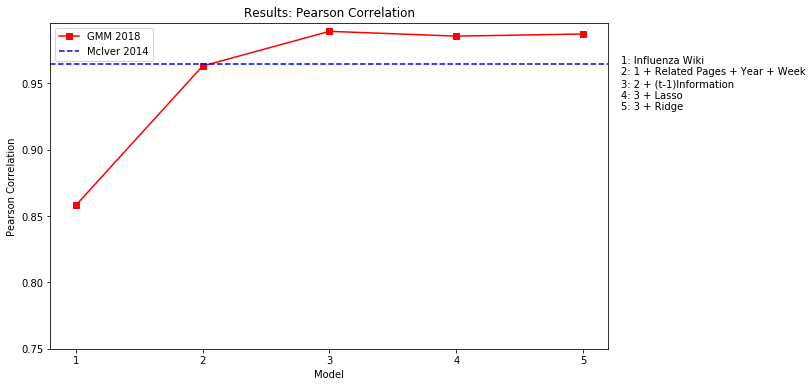

In [45]:
#Plot results
def plot_results(score_list, score, score_article, bottom, y):
    plt.figure(figsize=(10,6))
    n_model = list(range(1,len(score_list)+1))
    plt.plot(n_model, score_list, marker = "s", color = "r", label='GMM 2018')
    plt.title("Results: " + score)
    plt.xlabel('Model')
    plt.ylabel(score)
    xint = range(min(n_model), math.ceil(max(n_model))+1)
    plt.xticks(xint)
    plt.ylim(bottom=bottom) 
    plt.axhline(y=score_article, color='b', linestyle='--', label='McIver 2014')
    plt.legend()
    plt.text(5.3,y,"1: Influenza Wiki\n2: 1 + Related Pages + Year + Week\n3: 2 + (t-1)Information\n4: 3 + Lasso\n5: 3 + Ridge")
    plt.show()

plot_results(mse_list, "MSE", mean_mse_article, 0, 3)
plot_results(corr_list, "Pearson Correlation", corr_article, 0.75, 0.93)

Wikipedia analysis has strengths and weaknesses. Wikipedia users are not representative of the wider public. So any insights are partial.

## Reference

[1] D.J. McIver & J. S. Brownstein (2014), "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time", PLoS Comput Biol 10(4): e1003581
http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003581